In [290]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from scipy.stats import mannwhitneyu
from wordcloud import WordCloud

In [308]:
columns_to_keep_submissions = ['author', 'created_utc', 'subreddit', 'title', 'selftext', 'id', 'num_comments', 'num_crossposts', 'permalink']
columns_to_keep_comments = ['author', 'created_utc', 'subreddit', 'body', 'link_id', 'permalink']
anxiety_submission_df = pd.read_csv("../../data/thomas_MH/submissions/Anxiety/Anxiety_submissions.csv", usecols=columns_to_keep_submissions)
anxiety_comments_df = pd.read_csv("../../data/thomas_MH/comments/Anxiety/Anxiety_comments.csv", usecols=columns_to_keep_comments)

/tmp/ipykernel_30201/2624630898.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  anxiety_submission_df = pd.read_csv("../../data/thomas_MH/submissions/Anxiety/Anxiety_submissions.csv", usecols=columns_to_keep_submissions)
/tmp/ipykernel_30201/2624630898.py:4: DtypeWarning: Columns (1,2,13,14,43) have mixed types. Specify dtype option on import or set low_memory=False.
  anxiety_comments_df = pd.read_csv("../../data/thomas_MH/comments/Anxiety/Anxiety_comments.csv", usecols=columns_to_keep_comments)


In [309]:
def convert_to_datetime(df):
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
    return df

def clean_date(df):
    df['created_utc'] = pd.to_numeric(df['created_utc'], errors='coerce')
    df = df.dropna(subset=['created_utc'])
    df = convert_to_datetime(df)
    return df.reset_index(drop=True)

def clean_and_filter_by_years(df, years):
    df = clean_date(df)
    df = df[df['created_utc'].dt.year.isin(years)]
    return df.reset_index(drop=True)

def adjust_link_id(df):
    df.loc[:, 'link_id'] = df['link_id'].str.replace('t3_', '', regex=False)
    return df

def add_title_to_selftext(df):
    df['selftext'] = df['title'] + '\n' + df['selftext'].fillna('')
    return df

# Submissions
subs_pre_df = clean_and_filter_by_years(anxiety_submission_df, [2018, 2019])
subs_pre_df = add_title_to_selftext(subs_pre_df)

subs_post_df = clean_and_filter_by_years(anxiety_submission_df, [2020, 2021])
subs_post_df = add_title_to_selftext(subs_post_df)

# Comments
coms_pre_df = clean_and_filter_by_years(anxiety_comments_df, [2018, 2019])
coms_pre_df = adjust_link_id(coms_pre_df)

coms_post_df = clean_and_filter_by_years(anxiety_comments_df, [2020, 2021])
coms_post_df = adjust_link_id(coms_post_df)

/tmp/ipykernel_30201/3079510164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
/tmp/ipykernel_30201/3079510164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
/tmp/ipykernel_30201/3079510164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [310]:
def add_year_month_column(df):
    df['year.month'] = df['created_utc'].dt.to_period('M').dt.strftime('%y:%m')
    return df

def group_by_month(df):
    df_grouped = df.groupby('year.month').size().reset_index(name='num_entries')
    return df_grouped

# Apply grouping by month to the dataframes

# Submissions
subs_pre_df = add_year_month_column(subs_pre_df)
subs_pre_df_grouped = group_by_month(subs_pre_df)

subs_post_df = add_year_month_column(subs_post_df)
subs_post_df_grouped = group_by_month(subs_post_df)

# Comments
coms_pre_df = add_year_month_column(coms_pre_df)
coms_pre_df_grouped = group_by_month(coms_pre_df)

coms_post_df = add_year_month_column(coms_post_df)
coms_post_df_grouped = group_by_month(coms_post_df)

# Display the grouped dataframes
# display(anxiety_submission_pre_covid_grouped)
# display(anxiety_submission_post_covid_grouped)
# display(coms_pre_df_grouped)
# display(coms_pre_df_grouped)

# New Approach for Visualisation

In [312]:
# Aggregating submissions by 'year.month'
subs_pre_df['year.month'] = pd.to_datetime(subs_pre_df['created_utc']).dt.strftime('%Y-%m')
subs_post_df['year.month'] = pd.to_datetime(subs_post_df['created_utc']).dt.strftime('%Y-%m')

subs_pre_agg = subs_pre_df.groupby('year.month').agg(num_subs=('selftext', 'size')).reset_index()
subs_post_agg = subs_post_df.groupby('year.month').agg(num_subs=('selftext', 'size')).reset_index()

# display(subs_pre_agg)
# display(subs_post_agg)

In [311]:
# Grouping comment data by year.month to get monthly counts of comments
coms_pre_df['year.month'] = coms_pre_df['created_utc'].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))
coms_post_df['year.month'] = coms_post_df['created_utc'].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))

# Aggregating comments by 'year.month'
coms_pre_agg = coms_pre_df.groupby('year.month').agg(num_coms=('body', 'size')).reset_index()
coms_post_agg = coms_post_df.groupby('year.month').agg(num_coms=('body', 'size')).reset_index()

# display(coms_pre_agg)
# display(coms_post_agg)

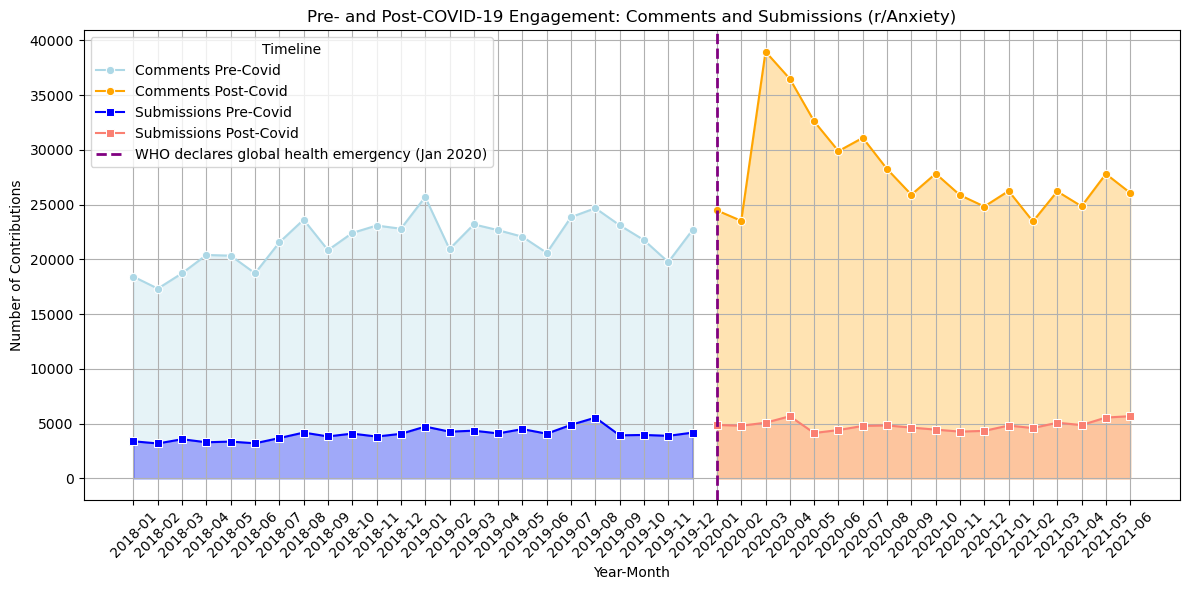

In [313]:
# Plotting
plt.figure(figsize=(12, 6))

# Shaded area and line plot for number of comments in Pre-Covid period
sns.lineplot(data=coms_pre_agg, x='year.month', y='num_coms', marker='o', label='Comments Pre-Covid', color='lightblue')
plt.fill_between(coms_pre_agg['year.month'], coms_pre_agg['num_coms'], alpha=0.3, color='lightblue')

# Shaded area and line plot for number of comments in Post-Covid period
sns.lineplot(data=coms_post_agg, x='year.month', y='num_coms', marker='o', label='Comments Post-Covid', color='orange')
plt.fill_between(coms_post_agg['year.month'], coms_post_agg['num_coms'], alpha=0.3, color='orange')

# Shaded area and line plot for number of submissions in Pre-Covid period
sns.lineplot(data=subs_pre_agg, x='year.month', y='num_subs', marker='s', label='Submissions Pre-Covid', color='blue')
plt.fill_between(subs_pre_agg['year.month'], subs_pre_agg['num_subs'], alpha=0.3, color='blue')

# Shaded area and line plot for number of submissions in Post-Covid period
sns.lineplot(data=subs_post_agg, x='year.month', y='num_subs', marker='s', label='Submissions Post-Covid', color='salmon')
plt.fill_between(subs_post_agg['year.month'], subs_post_agg['num_subs'], alpha=0.3, color='salmon')

# Vertical line marking January 2020
plt.axvline(x='2020-01', color='purple', linestyle='--', linewidth=2, label='WHO declares global health emergency (Jan 2020)')

# Formatting plot
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Number of Contributions')
plt.title('Pre- and Post-COVID-19 Engagement: Comments and Submissions (r/Anxiety)')
plt.legend(title='Timeline')
plt.grid(True)
plt.tight_layout()

# Save and show plot
plt.savefig('../../work/FCSS/pre_post_engagement.png', format='png', dpi=300)
plt.show()

# Most Active Months

In [299]:
display(coms_pre_agg.sort_values(by='num_coms', ascending=False)[['year.month', 'num_coms']].head(5))
display(coms_post_agg.sort_values(by='num_coms', ascending=False)[['year.month', 'num_coms']].head(5))
display(subs_pre_agg.sort_values(by='num_subs', ascending=False)[['year.month', 'num_subs']].head(5))
display(subs_post_agg.sort_values(by='num_subs', ascending=False)[['year.month', 'num_subs']].head(5))

,year.month,num_coms
12,2019-01,25694
19,2019-08,24673
18,2019-07,23858
7,2018-08,23625
14,2019-03,23194


,year.month,num_coms
2,2020-03,38963
3,2020-04,36483
4,2020-05,32600
6,2020-07,31098
5,2020-06,29883


,year.month,num_subs
19,2019-08,5549
18,2019-07,4889
12,2019-01,4731
16,2019-05,4500
14,2019-03,4355


,year.month,num_subs
17,2021-06,5681
3,2020-04,5676
16,2021-05,5555
14,2021-03,5084
2,2020-03,5082


In [318]:
# Drop NaN values
coms_pre_df = coms_pre_df.dropna()
coms_post_df = coms_post_df.dropna()

# Grouping and aggregating, including a count of comments
grouped_coms_pre_df = coms_pre_df.groupby('link_id', as_index=False).agg(comments=('Text', ' '.join), num_coms=('Text', 'size'))

grouped_coms_post_df = coms_post_df.groupby('link_id', as_index=False).agg(comments=('Text', ' '.join), num_coms=('Text', 'size'))

grouped_coms_pre_df = grouped_coms_pre_df.rename(columns={'link_id': 'id'})
grouped_coms_post_df = grouped_coms_post_df.rename(columns={'link_id': 'id'})

display(grouped_coms_pre_df.sort_values(by="num_coms", ascending=False))
display(grouped_coms_post_df.sort_values(by="num_coms", ascending=False))

,id,comments,num_coms
59018,b8ltlf,Have a very happy birthday! Happy birthday!! H...,650
1444,7poipc,This AMA has been approved by the moderators o...,442
49853,al7x83,That's pretty damn infuriating. Your mom seems...,342
51600,ap60qf,"You should be! That’s epic, it might sound wei...",340
20870,8v7aqr,Your great dude/miss\n\nu/hoping_pessimist Thi...,309
...,...,...,...
49948,algcl8,TRIGGER WARNING: WEIGHT AND SCALE NUMBERS\n\n&...,1
17680,8of2u9,I am very much in the same boat. I used to be ...,1
17686,8ofrki,Have you spoke to your doctor about putting yo...,1
49943,alfs36,"Hey, you're not a burden. Feel free to messsge...",1


,id,comments,num_coms
12774,fj2y1a,17 day old recovers https://trib.al/O0VcjZn mo...,18287
14157,fnz5n3,Dope. The other thread was massive. Let’s keep...,13809
4890,eupik4,U/ohsheglows is a mod! :) I just started on im...,10073
44969,ioy7uo,Saved thanks again! Thanks!!! California's rat...,2904
27443,h036q3,2020 is shaping up to be really fucking shitty...,2078
...,...,...,...
18279,g4fihj,I don't have any solutions to this but I can o...,1
49357,j4bdvu,If the detector isn’t going off and you still ...,1
49355,j4ba3t,Intrusive thoughts for sure! I get cringe thou...,1
49354,j4b9sm,"Yes, I feel the same way. Every day I wake up ...",1


# Merge Commentsection to the matching Submission based on id and link_id

In [321]:
# merged_pre_df = sub_pre_df.merge(grouped_coms_pre_df, how='left', left_on='id', right_on='id')
# merged_post_df = sub_post_df.merge(grouped_coms_post_df, how='left', left_on='id', right_on='id')

# NEW VERSION
# Rename 'created_utc' in the comments DataFrames to avoid conflicts during merge
# grouped_coms_pre_df = grouped_coms_pre_df.rename(columns={'created_utc': 'comments_created_utc'})
# grouped_coms_post_df = grouped_coms_post_df.rename(columns={'created_utc': 'comments_created_utc'})
# display(grouped_coms_pre_df)

# Perform an outer merge to include all rows from both DataFrames
merged_pre_df = sub_pre_df.merge(grouped_coms_pre_df, how='outer', on='id')
merged_post_df = sub_post_df.merge(grouped_coms_post_df, how='outer', on='id')

# Fill NaN values in 'comments' and 'num_coms' with placeholders
merged_pre_df['comments'].fillna('-', inplace=True)
merged_post_df['comments'].fillna('-', inplace=True)
merged_pre_df['num_coms'].fillna(0, inplace=True)
merged_post_df['num_coms'].fillna(0, inplace=True)

# Replace NaN in 'created_utc' with 'comments_created_utc' when 'created_utc' is missing
# merged_pre_df['created_utc'] = merged_pre_df['created_utc'].fillna(merged_pre_df['comments_created_utc'])
# merged_post_df['created_utc'] = merged_post_df['created_utc'].fillna(merged_post_df['comments_created_utc'])

# Drop the now redundant 'comments_created_utc' column, as it's no longer needed
# merged_pre_df.drop(columns=['comments_created_utc'], inplace=True)
# merged_post_df.drop(columns=['comments_created_utc'], inplace=True)

# Check the result
display(merged_pre_df.head())
display(merged_post_df.head())

,author,created_utc,id,num_comments,num_crossposts,permalink,subreddit,title,ColumnID,submission,...,Emoji,VADER_compound,VADER_scaled,BERT_sentiment,BERT_label,BERT_score,LIWC_Sentiment,VADER_Sentiment,comments,num_coms
0,welcomenope,2018-01-01 00:01:12,7nby40,2.0,0.0,/r/Anxiety/comments/7nby40/my_mom_is_crying_be...,Anxiety,My Mom is crying because i refused to call to ...,selftext,My Mom is crying because i refused to call to ...,...,0.0,-0.9480,2.595260,"('NEGATIVE', 0.9978119134902954)",NEGATIVE,0.997812,Negative,Negative,Tell her straight up what is going on. She is ...,2.0
1,Sqrqol,2018-01-01 00:17:23,7nc19c,5.0,0.0,/r/Anxiety/comments/7nc19c/how_to_deal_with_he...,Anxiety,How to deal with 'heart attacks' every night?,selftext,How to deal with 'heart attacks' every night?\...,...,0.0,-0.0258,48.709871,"('NEGATIVE', 0.9984802603721619)",NEGATIVE,0.998480,Negative,Neutral,What is really helpful for me is when I feel i...,5.0
2,CaptainCarlyle,2018-01-01 02:15:15,7ncmtd,11.0,0.0,/r/Anxiety/comments/7ncmtd/how_does_it_feel_to...,Anxiety,How does it feel to not have anxiety?,selftext,How does it feel to not have anxiety?\n I've h...,...,0.0,-0.9647,1.760176,"('POSITIVE', 0.9808213710784912)",POSITIVE,0.980821,Negative,Negative,It’s like how it is on Xanax. I've never had X...,11.0
3,atc05040,2018-01-01 02:35:18,7ncq8n,5.0,0.0,/r/Anxiety/comments/7ncq8n/i_could_do_with_som...,Anxiety,I could do with some advice. Im really struggl...,selftext,I could do with some advice. Im really struggl...,...,0.0,-0.9823,0.880088,"('NEGATIVE', 0.9890487194061279)",NEGATIVE,0.989049,Negative,Negative,Just to clarify when I say I hear noises in my...,5.0
4,leonardfurnstein,2018-01-01 02:35:53,7ncqd7,4.0,0.0,/r/Anxiety/comments/7ncqd7/stuck_at_a_party/,Anxiety,Stuck at a party,selftext,Stuck at a party\nI’m at a completely fine NYE...,...,0.0,0.9258,96.294629,"('NEGATIVE', 0.9993731379508972)",NEGATIVE,0.999373,Neutral,Positive,I know how that feels. Can you find a quieter ...,4.0


,author,created_utc,id,num_comments,num_crossposts,permalink,subreddit,title,ColumnID,submission,...,Emoji,VADER_compound,VADER_scaled,BERT_sentiment,BERT_label,BERT_score,LIWC_Sentiment,VADER_Sentiment,comments,num_coms
0,Single_gay_mom,2020-01-01 00:03:16,eib1fl,0.0,0.0,/r/Anxiety/comments/eib1fl/started_out_my_new_...,Anxiety,Started out my New Years with bailing on a party.,selftext,Started out my New Years with bailing on a par...,...,3.85,0.8225,91.125,"('POSITIVE', 0.9994174242019653)",POSITIVE,0.999417,Positive,Positive,-,0.0
1,StormRider21,2020-01-01 00:06:39,eib34y,1.0,0.0,/r/Anxiety/comments/eib34y/fireworks_give_me_a...,Anxiety,"Fireworks give me anxiety and it's new year, g...",selftext,"Fireworks give me anxiety and it's new year, g...",...,0.00,-0.3147,34.265,"('POSITIVE', 0.9924788475036621)",POSITIVE,0.992479,Negative,Neutral,I've lived in a country where I've experienced...,1.0
2,Rikc16,2020-01-01 00:15:10,eib6ym,0.0,0.0,/r/Anxiety/comments/eib6ym/happy_new_year_ever...,Anxiety,Happy new year everyone!,selftext,Happy new year everyone!\nHere’s hoping we all...,...,2.38,0.9059,95.295,"('POSITIVE', 0.9924222826957703)",POSITIVE,0.992422,Positive,Positive,-,0.0
3,wolksvagon,2020-01-01 00:25:54,eibbse,4.0,0.0,/r/Anxiety/comments/eibbse/need_advice_on_how_...,Anxiety,Need advice on how I can help my wife.,selftext,Need advice on how I can help my wife.\nHello ...,...,0.00,-0.9217,3.915,"('POSITIVE', 0.9964742064476013)",POSITIVE,0.996474,Negative,Negative,I think you need to encourage her to go to the...,4.0
4,hoecakes_,2020-01-01 00:36:13,eibgmd,2.0,0.0,/r/Anxiety/comments/eibgmd/i_have_really_bad_s...,Anxiety,I have really bad social anxiety,selftext,I have really bad social anxiety\nit’s gotten ...,...,0.00,-0.9545,2.275,"('NEGATIVE', 0.9960577487945557)",NEGATIVE,0.996058,Negative,Negative,Yes!! I feel the same exact way. It’s really s...,1.0


# Wordcloud for Pre and Post Covid Period

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


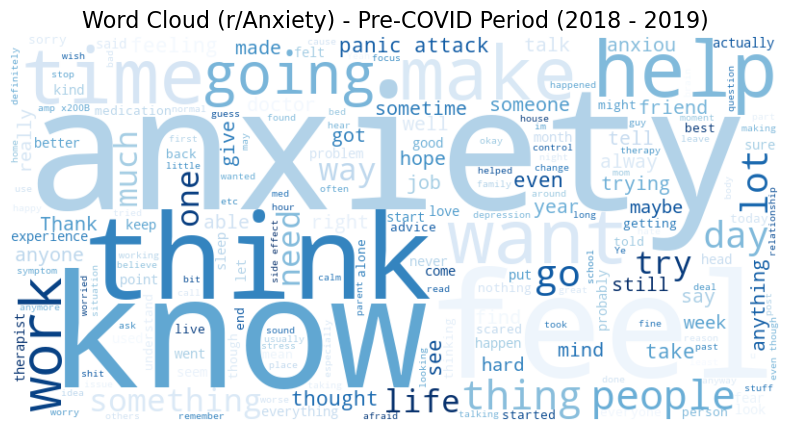

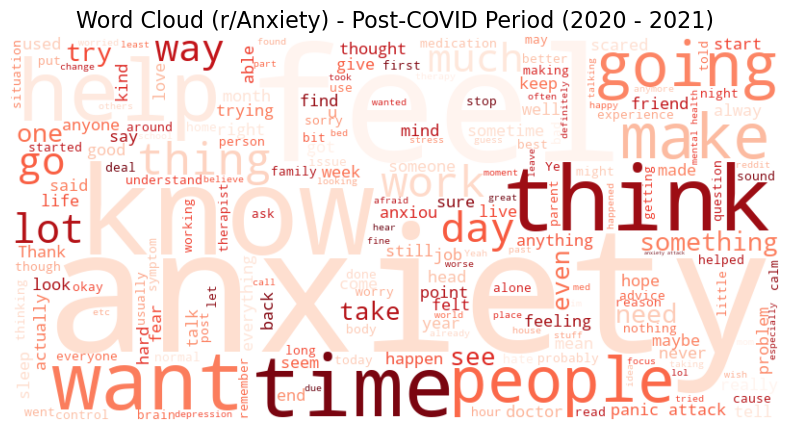

CPU times: user 4min 52s, sys: 17.1 s, total: 5min 9s
Wall time: 5min 8s


In [325]:
%%time
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt

nltk.download('stopwords')

# combine stopwords from wordcloud and nltk
custom_stopwords = set(STOPWORDS).union(set(stopwords.words('english')))

pre_covid_text = " ".join(merged_pre_df['submission'].fillna('') + " " + merged_pre_df['comments'].fillna(''))
post_covid_text = " ".join(merged_post_df['submission'].fillna('') + " " + merged_post_df['comments'].fillna(''))

# word clouds with stopword removal
pre_covid_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                                colormap='Blues', stopwords=custom_stopwords).generate(pre_covid_text)

post_covid_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                                 colormap='Reds', stopwords=custom_stopwords).generate(post_covid_text)


# pre-COVID word cloud
plt.figure(figsize=(10, 5))
plt.imshow(pre_covid_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (r/Anxiety) - Pre-COVID Period (2018 - 2019)", fontsize=16)
plt.savefig('../../work/FCSS/word_cloud_pre_covid.png', format='png', dpi=300)

plt.show()

# post-COVID word cloud
plt.figure(figsize=(10, 5))
plt.imshow(post_covid_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (r/Anxiety) - Post-COVID Period (2020 - 2021)", fontsize=16)
plt.savefig('../../work/FCSS/word_cloud_post_covid.png', format='png', dpi=300)
plt.show()